# **Importing Libraries**

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from PIL import Image
from keras.utils import plot_model
from zipfile import ZipFile, BadZipFile
import random as r
import warnings
warnings.filterwarnings('ignore')

# **Exploring The Data**

In [5]:
train_path = '/kaggle/input/plant-disease-recognition-dataset/Train/Train'
test_path = '/kaggle/input/plant-disease-recognition-dataset/Test/Test'
validation_path = '/kaggle/input/plant-disease-recognition-dataset/Validation/Validation'

In [6]:
os.listdir(validation_path)

['Healthy', 'Rust', 'Powdery']

In [9]:
def count_files_in_folder(path):
  folder_data = []
  for fol in os.listdir(path):
    folder_path = os.path.join(path, fol)
    fil = os.listdir(folder_path)
    num_files = 0
    for item in fil:
      if os.path.isfile(os.path.join(folder_path, item)):
        num_files +=1

    folder_data.append([fol, num_files])


  return folder_data

In [10]:
train_data = count_files_in_folder(train_path)
test_data = count_files_in_folder(test_path)
validation_data = count_files_in_folder(validation_path)

In [11]:
train_df = pd.DataFrame(train_data, columns = ['Folder', 'Total Files'])
test_df = pd.DataFrame(test_data, columns = ['Folder', 'Total Files'])
validation_df = pd.DataFrame(validation_data, columns = ['Folder', 'Total Files'])

In [12]:
train_df['Type'] = 'Train'
test_df['Type'] = 'Test'
validation_df['Type'] = 'Validation'

In [13]:
combined_df = pd.concat([train_df, test_df, validation_df])

In [14]:
combined_df

Folder  Total Files        Type
0  Healthy          458       Train
1     Rust          434       Train
2  Powdery          430       Train
0  Healthy           50        Test
1     Rust           50        Test
2  Powdery           50        Test
0  Healthy           20  Validation
1     Rust           20  Validation
2  Powdery           20  Validation

<Axes: xlabel='Folder', ylabel='Total Files'>

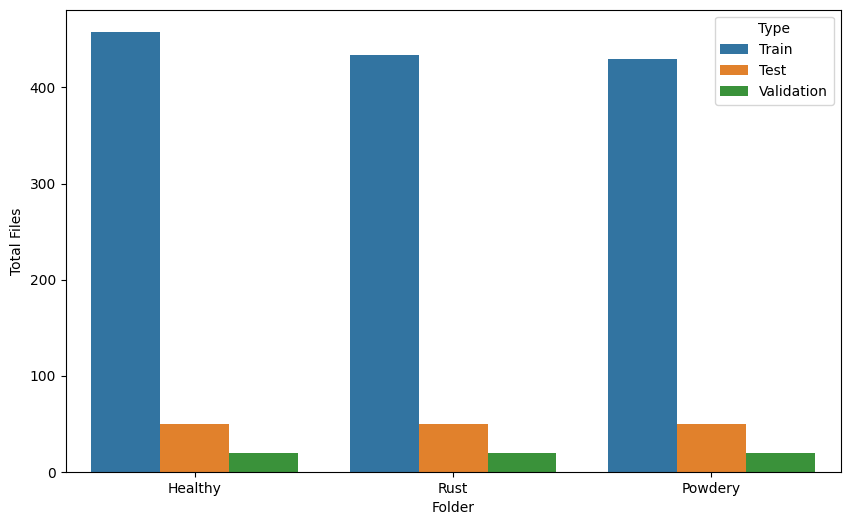

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'Folder', y ='Total Files', hue ='Type', data =combined_df)

In [16]:
def plot_sample_img(path_folder, sample_size = 5):
  images =[]
  all_file = [f for f in os.listdir(path_folder) if os.path.isfile(os.path.join(path_folder, f))]
  sample_file = r.sample(all_file, sample_size)

  for img in sample_file:
    path = os.path.join(path_folder, img)
    image = Image.open(path)
    images.append(image)

  return images

In [17]:
train_healthy = '/kaggle/input/plant-disease-recognition-dataset/Train/Train/Healthy'
train_Powdery = '/kaggle/input/plant-disease-recognition-dataset/Train/Train/Powdery'
train_Rust = '/kaggle/input/plant-disease-recognition-dataset/Train/Train/Rust'

In [18]:
healthy_img = plot_sample_img(train_healthy)
powdery_img = plot_sample_img(train_Powdery)
rust_img = plot_sample_img(train_Rust)

In [19]:
all_img = [healthy_img, powdery_img,  rust_img]

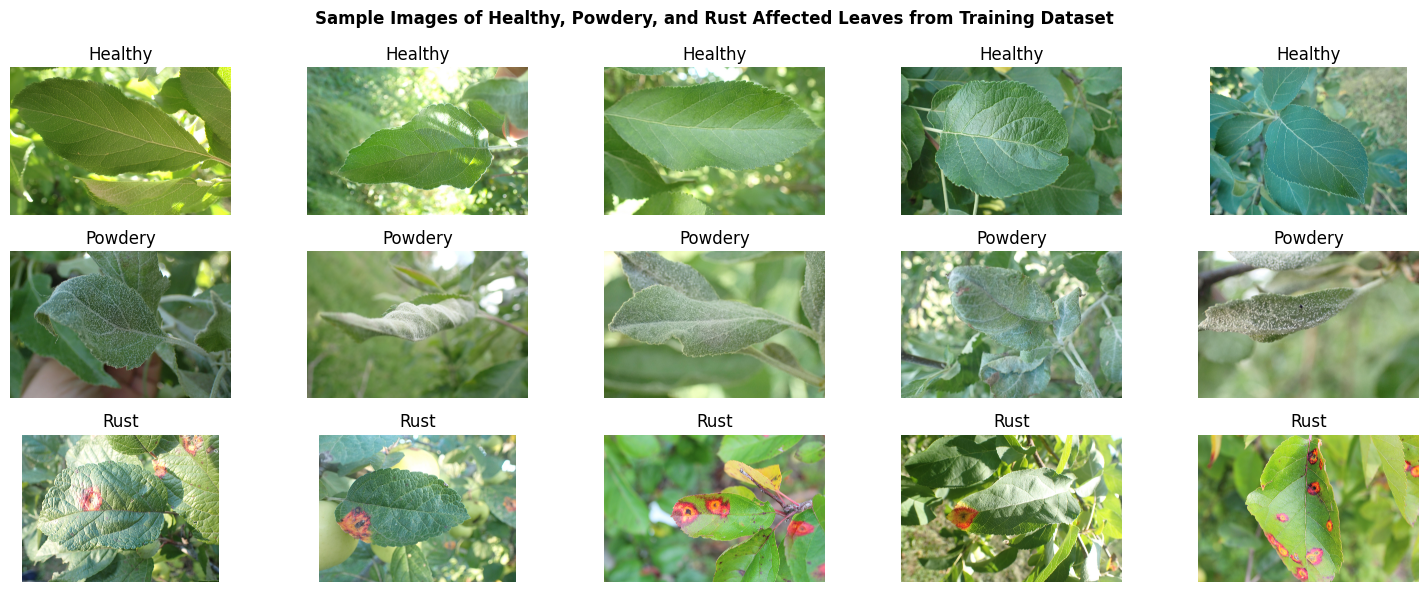

In [20]:
fig, axes = plt.subplots(3, len(healthy_img), figsize=(15,6))
title = ['Healthy', 'Powdery', 'Rust']
for row, category in enumerate(all_img):
  for i, img in enumerate(category):
    axes[row, i].imshow(img)
    axes[row, i].set_title(title[row])
    axes[row, i].axis('off')

plt.suptitle('Sample Images of Healthy, Powdery, and Rust Affected Leaves from Training Dataset', fontweight='bold')
plt.tight_layout()
plt.show()

# **Data Augmentation**

In [23]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen =  ImageDataGenerator(rescale = 1./255)

In [24]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(test_path,
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(validation_path,
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode = 'categorical')

Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [25]:
train_generator.class_indices

{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

# **Creating Model**

In [26]:
model = Sequential()

model.add(Conv2D(56, kernel_size = (3,3), activation = 'relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(28, kernel_size = (3,3), activation = 'relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((3,3)))

model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
16
model.add(Dense(32, activation = 'relu'))
model.add(Dense(14, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))

In [27]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [29]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.3648 - loss: 1.1152 - val_accuracy: 0.4833 - val_loss: 0.9159
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.5520 - loss: 0.8887 - val_accuracy: 0.5167 - val_loss: 0.8160
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.6094 - loss: 0.7945 - val_accuracy: 0.6167 - val_loss: 0.6607
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6914 - loss: 0.6817 - val_accuracy: 0.8333 - val_loss: 0.4878
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.8378 - loss: 0.4674 - val_accuracy: 0.7833 - val_loss: 0.4261
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.8565 - loss: 0.3932 - val_accuracy: 0.7833 - val_loss: 0.5227
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.8976 - loss: 0.2957 - val_accuracy: 0.9167 - val_loss: 0.3248
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9158 - loss: 0.2934 - val_accuracy: 0.8500 - v

# **Loss & Accuracy**

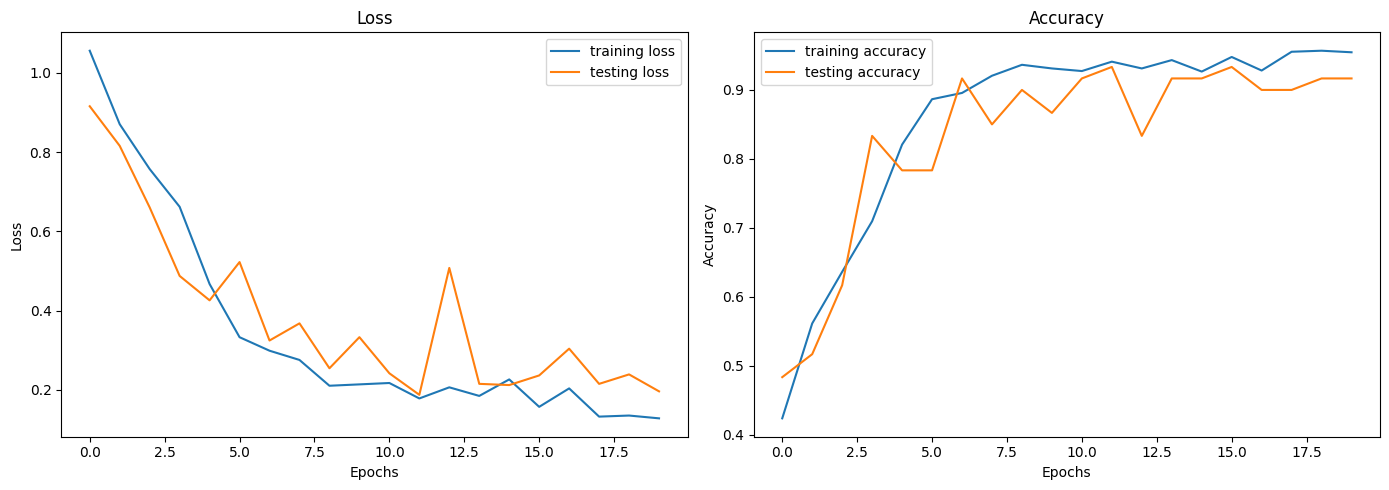

In [30]:
fig, axes = plt.subplots(1,2 , figsize =(14, 5))

sns.lineplot(ax = axes[0], data = history.history['loss'], label = 'training loss' )
sns.lineplot(ax= axes[0], data = history.history['val_loss'], label = 'testing loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

sns.lineplot(ax = axes[1], data = history.history['accuracy'], label = 'training accuracy')
sns.lineplot(ax = axes[1], data = history.history['val_accuracy'], label = 'testing accuracy')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

# **Evaluation**

In [31]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9479 - loss: 0.1690
Testing Loss: 0.21941401064395905
Testing Accuracy: 0.9399999976158142


# **Model Prediction**

In [36]:
def process_image(img, target_size=(224, 224)):
    # If img is a path, load the image
    if isinstance(img, str):
        img = image.load_img(img, target_size=target_size)
    else:
        # If img is a PIL image, resize it
        img = img.resize(target_size)
    
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

In [37]:
test_healthy = '/kaggle/input/plant-disease-recognition-dataset/Test/Test/Healthy'
test_Powdery = '/kaggle/input/plant-disease-recognition-dataset/Test/Test/Powdery'
test_Rust = '/kaggle/input/plant-disease-recognition-dataset/Test/Test/Rust'

In [38]:
img_healthy = plot_sample_img(test_healthy)
img_Powdery = plot_sample_img(test_Powdery)
img_Rust = plot_sample_img(test_Rust)

In [39]:
train_generator.class_indices

{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


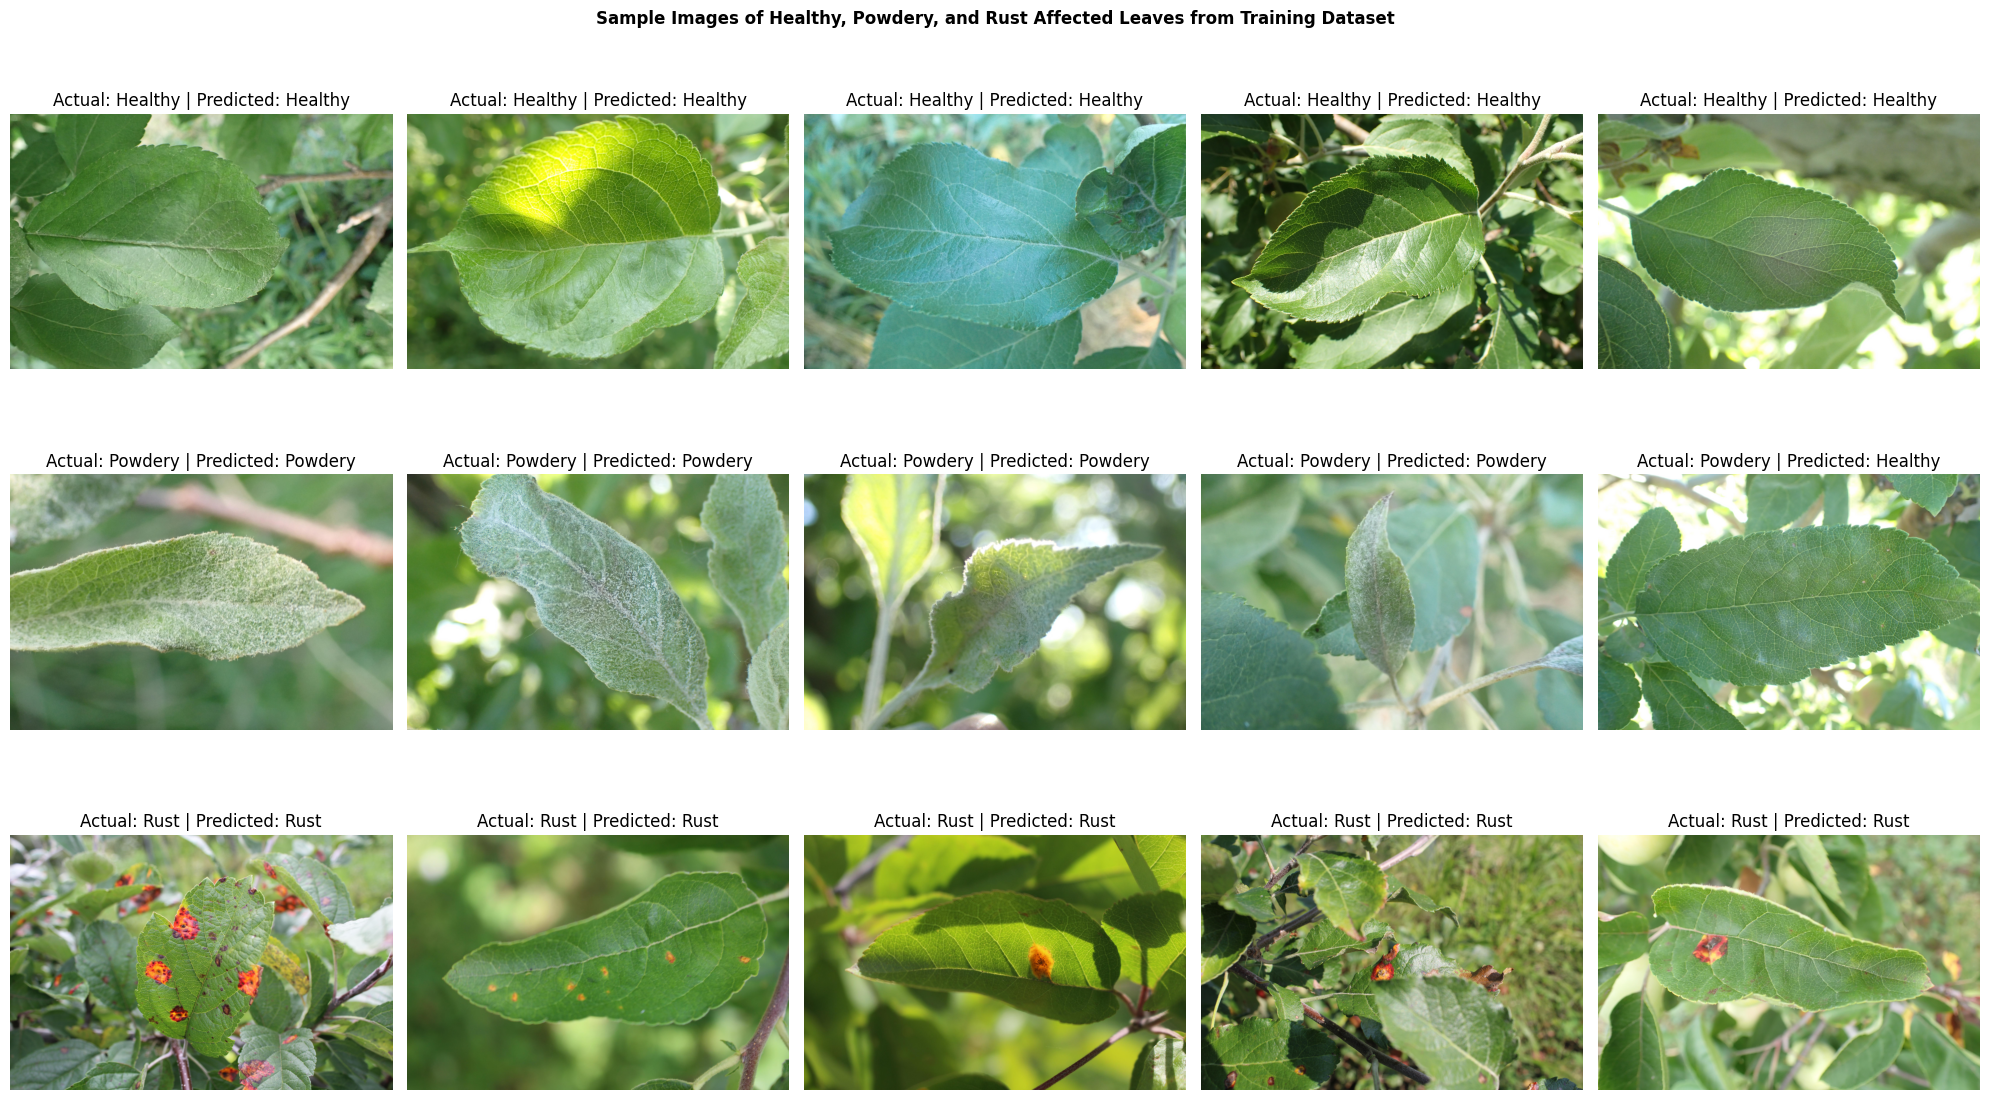

In [41]:
test_img = [img_healthy, img_Powdery, img_Rust]
fig, axes = plt.subplots(3, len(healthy_img), figsize=(20,12))
title = ['Actual: Healthy', 'Actual: Powdery', 'Actual: Rust']
for row, category in enumerate(test_img):
  for i, img in enumerate(category):
    processed_img = process_image(img)
    pred = model.predict(processed_img)
    ind = np.argmax(pred)
    
    if ind == 0:
        pred_title = ' | Predicted: Healthy'
    elif ind == 1:
        pred_title = ' | Predicted: Powdery'
    else: 
        pred_title = ' | Predicted: Rust'
    axes[row, i].imshow(img)
    axes[row, i].set_title(title[row] + pred_title)
    axes[row, i].axis('off')

plt.suptitle('Sample Images of Healthy, Powdery, and Rust Affected Leaves from Training Dataset', fontweight='bold')
plt.tight_layout()
plt.show()

In [43]:
import pickle

In [44]:
with open('plant_disease.pkl', 'wb') as file:
    pickle.dump(model, file)